# Load

In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
df.columns = df.columns.str.lower()
num = df.select_dtypes(include='number').columns.to_list()
cat = df.select_dtypes(include='object').columns.to_list()
target = 'calories'
num.remove(target)

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=.2)

# Data Science

In [3]:
df[num].corrwith(df[target]).sort_values(ascending=False)

duration      0.959908
heart_rate    0.908748
body_temp     0.828671
age           0.145683
weight        0.015863
id            0.001148
height       -0.004026
dtype: float64

# Machine

In [4]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [5]:
processor = make_column_transformer(
    (make_pipeline(SimpleImputer(), StandardScaler()), num)
    , (OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat)
)

processor.fit(train)
train_pre = processor.transform(train)

In [6]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [7]:
lin = LinearRegression()
lin.fit(train_pre, train[target])
print(-cross_val_score(lin, train_pre, train[target], scoring='neg_root_mean_squared_error').mean())
print(cross_val_score(lin, train_pre, train[target], scoring='r2').mean())

11.07195560601276
0.9684844719307227


In [8]:
rdg = Ridge()
rdg.fit(train_pre, train[target])
print(-cross_val_score(rdg, train_pre, train[target], scoring='neg_root_mean_squared_error').mean())
print(cross_val_score(rdg, train_pre, train[target], scoring='r2').mean())

11.071955608339271
0.9684844719261715


In [9]:
# rfr = RandomForestRegressor()
# rfr.fit(train_pre, train[target])
# pd.DataFrame(cross_validate(rfr, train_pre, train[target], scoring=['neg_root_mean_squared_error', 'r2'])).mean()

In [10]:
model = lin
pipe = make_pipeline(processor, lin)

# Residuals

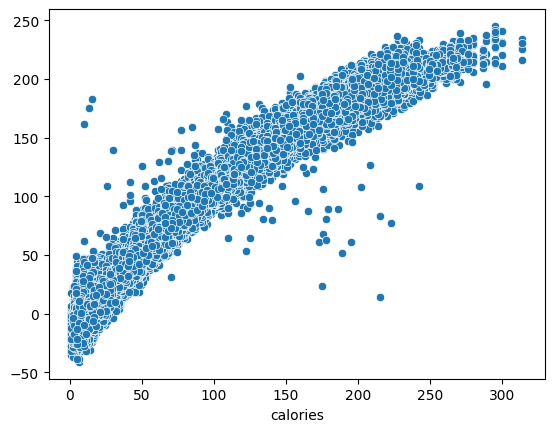

In [11]:
preds = pipe.predict(test)
sns.scatterplot(x=test[target], y=preds);

# Submission

In [12]:
samp = pd.read_csv('/kaggle/input/playground-series-s5e5/test.csv')

In [13]:
samp.columns = samp.columns.str.lower()

In [14]:
preds = np.array(pipe.predict(samp))
preds[preds < 0] = 0
pd.DataFrame({
    'id': samp['id']
    , 'Calories': preds
}).to_csv('submission.csv', index=False)